# Quantitative Risk Management: Portfolio Optimization, CAPM Hedging, and Monte Carlo VaR Simulation

## Project Overview

This notebook demonstrates how to estimate the Value-at-Risk (VaR) of an equity portfolio constructed from S&P 500 stocks. We optimize the portfolio using historical log returns, hedge its market exposure via a CAPM-based short position in S&P 500 futures, and simulate the portfolio's return distribution using Geometric Brownian Motion. Finally, we compute and compare the VaR for both hedged and unhedged cases at a 99% confidence level.

### Main Steps:

 1. **Data Collection and Preprocessing**
 2. **Portfolio Optimization**
 3. **Hedging via CAPM**
 4. **Monte Carlo VaR**
 5. **Conclusion**


## 1. Data Collection and Preprocessing

We start by collecting the historical (daily) closing prices of all S&P 500 companies using Yahoo Finance. We then clean the dataset by removing stocks with excessive missing data and compute the log-returns. This data will serve as the basis for portfolio optimization and risk analysis.


In [ ]:
#Install and import libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as sco
from scipy.cluster import hierarchy
import datetime
from scipy.stats import norm
import statsmodels.api as sm

In [ ]:
#Define utility functions:

def get_list(): #Download the list of symbols
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)
    sp500_table = table[0]
    return sorted(sp500_table['Symbol'].tolist())

def get_data(tickers, period): #Download the closing prices for given tickers and period
    data = yf.download(tickers, period = period)['Close']
    return pd.DataFrame(data)

def NaN_cleaner(data): #Handle the missing values
  NaN_count = data.isna().sum()
  clean = data
  for stock in data.columns.tolist():
    if NaN_count[stock]/ len(data) > 0.05:
      clean.drop(columns=stock, inplace=True)
  clean.ffill(inplace=True)
  clean.bfill(inplace=True)
  return clean

def log_returns_calc(data): #Calculate annualized log-returns
  return np.log(data / data.shift(1))[1:]


In [ ]:
#Data collection and cleaning:

tickers = get_list()
period = "5y" #Period of the historical data
raw_data = get_data(tickers, period)
cleaned_data = NaN_cleaner(raw_data)

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')


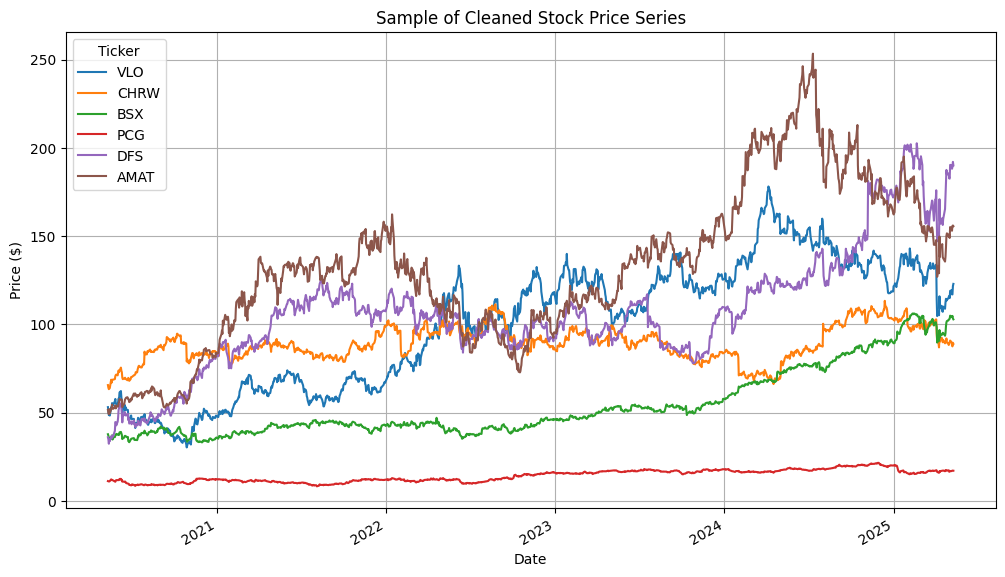

In [ ]:
#Visualization:

cleaned_data[np.random.choice(cleaned_data.columns.tolist(), 6, replace=False)].plot(figsize=(12, 7))
plt.title("Sample of Cleaned Stock Price Series")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [ ]:
#Setup the data for the next steps:

Rf = 0.0315 #Risk-free interest rate
n_trading = 252 #number of trading days (for a year, 252 in France)
log_returns = log_returns_calc(cleaned_data)

## 2. Portfolio Optimization

In this section, we will optimize the portfolio by maximizing the Sharpe ratio. We will calculate portfolio returns and volatility, perform a constrained optimization to find the optimal weights, and visualize the efficient frontier along with the optimal portfolio.



In [ ]:
#Portfolio performance functions:

def statistics(data, n_trading): #Calculate mean, covariance matrix and the standard deviation of each column
  mean = data.mean() * n_trading
  cov = data.cov() * n_trading
  std = data.var() * np.sqrt(n_trading)
  return [mean, cov, std]

def stats(weight, mean, cov): #Calculate the expected, standard deviation, and the Sharpe ratio of the portfolio for a given weight
  mu = weight @ mean
  sigma = np.sqrt(weight @ cov @ weight.T)
  sharpe = (mu - Rf) / sigma
  return [mu, sigma, sharpe]

def Sharpe_ratio(weight):#-Sharpe ratio, to be minimized:
  return stats(weight, mu, sigma)[2] * -1

In [ ]:
#Optimization functions:

def domination_detector(mean, std): #drop the dominated stocks, you can loosen this step by increasing p
  dominated = []
  for stocks1 in mean.index:
    for stocks2 in mean.index:
      if stocks1 == stocks2:
        continue
      elif mean[stocks1]*p < mean[stocks2] and std[stocks1] > std[stocks2]*p:
        dominated.append(stocks1)
        break
      else:
        continue
  return dominated

def optimize(): #maximize the maximized Sharpe ratio and return the corresponding weights
  constraints = {'type': 'eq', 'fun': lambda x: np.sum(x)-1}
  bounds = tuple((0,1) for _ in range(log_returns.shape[1]))
  initial_weights = np.ones(log_returns.shape[1]) / log_returns.shape[1]
  result =  sco.minimize(fun=Sharpe_ratio, x0=initial_weights,
                       method='SLSQP', bounds=bounds, constraints=constraints)
  return np.array(result.x)

def optimal_weighting(opt_weight): #Drop the stocks with weight zero and return the remaining stocks and their weights
    weights = pd.DataFrame(opt_weight.round(3)*100, columns=['percentage'], index=log_returns.columns)
    for stocks in weights.index.tolist():
        if weights['percentage'][stocks] == 0:
            weights.drop(index=stocks, inplace=True)
    return weights


The investment is divided between the following stocks:



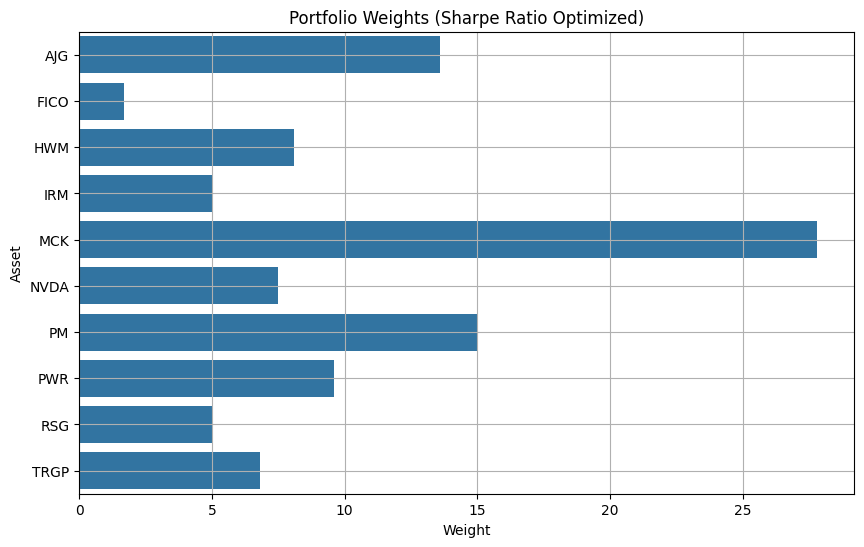


        percentage
Ticker            
AJG           13.6
FICO           1.7
HWM            8.1
IRM            5.0
MCK           27.8
NVDA           7.5
PM            15.0
PWR            9.6
RSG            5.0
TRGP           6.8

Expected Return: 35.98%
Volatility: 17.83%
Sharpe Ratio: 1.84


In [ ]:
#Optimize:

mu1, sigma1, std1 = statistics(log_returns, n_trading)
p = 1.05 # p=1 is standard, increase to keep more stocks in the list
log_returns = log_returns.drop(columns = domination_detector(mu1, std1))
cleaned_data = cleaned_data.drop(columns = domination_detector(mu1, std1))
mu, sigma, std = statistics(log_returns, n_trading)
optimal_weights = optimize()
print("")
print("The investment is divided between the following stocks:")
print("")
w_list = optimal_weighting(optimal_weights)
opt_weights_df = pd.DataFrame({'Asset': w_list.index.tolist(), 'Weight': w_list['percentage']})
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Asset', data=opt_weights_df)
plt.title("Portfolio Weights (Sharpe Ratio Optimized)")
plt.xlabel("Weight")
plt.ylabel("Asset")
plt.grid(True)
plt.show()
print("")
opt_mu, opt_sigma, opt_sharpe = stats(optimal_weights, mu, sigma)

print(w_list)
print("")
print(f"Expected Return: {opt_mu:.2%}")
print(f"Volatility: {opt_sigma:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

In [ ]:
#Visualization functions

def weight_generator_stats(mean, cov):
  weight = []
  mu = []
  sigma = []
  Sharpe = []
  for _ in range(10000):
    weights = np.random.random(log_returns.shape[1])
    weights /= np.sum(weights)
    weight.append(weights)
    mu.append(stats(weights, mean, cov )[0])
    sigma.append(stats(weights, mean, cov )[1])
    Sharpe.append(stats(weights, mean, cov )[2])
  return [np.array(weight), np.array(mu), np.array(sigma), np.array(Sharpe)]

def show_portfolio(sim_mu, sim_sigma, sim_sharpe, opt_mu, opt_sigma, opt_sharpe, Rf=0.0): #Plots the simulated and the optimal portfolio on the mean-variance plane
    sim_mu = np.array(sim_mu)
    sim_sigma = np.array(sim_sigma)
    sharpe_vals = (sim_mu - Rf) / sim_sigma

    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(sim_sigma, sim_mu, c=sharpe_vals, cmap='viridis', marker='o', alpha=0.5)
    plt.scatter(opt_sigma, opt_mu, c='red', marker='*', s=500,
                label=f'Optimal (Sharpe={opt_sharpe:.2f})')
    plt.grid(True)
    plt.xlabel('Volatility')
    plt.ylabel('Expected Return')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sharpe Ratio')
    plt.legend()
    plt.title("Efficient Frontier (Color = Sharpe Ratio)")
    plt.show()


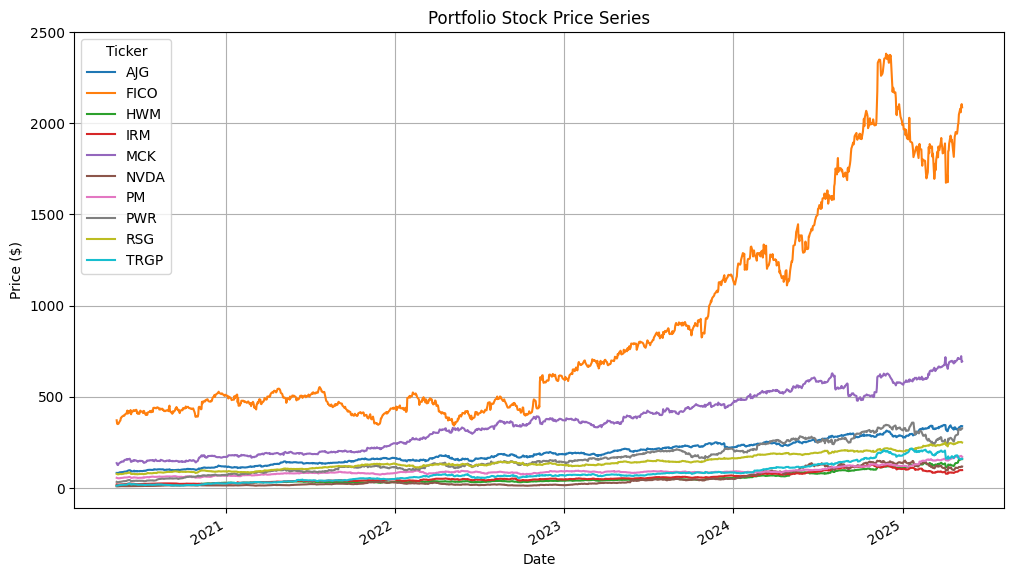

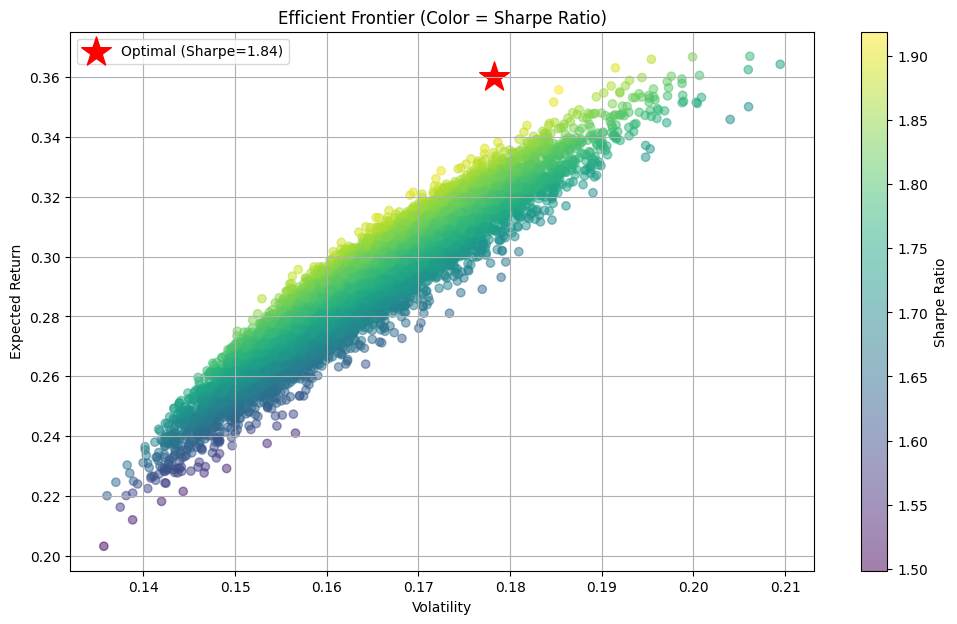

In [ ]:
#Visualization:

cleaned_data[optimal_weighting(optimal_weights).index.tolist()].plot(figsize=(12, 7))
plt.title("Portfolio Stock Price Series")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

weight, simulated_mu, simulated_sigma, simulated_sharpe = weight_generator_stats(mu, sigma)

optimal_mu, optimal_sigma, optimal_sharpe = stats(optimal_weights, mu, sigma)
show_portfolio(simulated_mu, simulated_sigma,simulated_sharpe, optimal_mu, optimal_sigma, optimal_sharpe)

##3. Hedging via CAPM
We estimate the portfolio’s beta using CAPM by regressing its returns against the S&P 500. This beta helps determine the number of futures contracts needed to hedge systematic risk.

In [ ]:
#Get market and portfolio return data:

ticker_market = ["^GSPC"]+ log_returns.columns.tolist()
raw_port_market = get_data(ticker_market, period)
cleaned_port_data = NaN_cleaner(raw_port_market)
log_returns_port_market = log_returns_calc(cleaned_port_data)
market_data = log_returns_port_market["^GSPC"]
port_data = log_returns_port_market.drop(columns=["^GSPC"]) @ optimal_weights
data_port_market = pd.concat([market_data, port_data], axis=1)
data_port_market.columns = ["market", "portfolio"]


[*********************100%***********************]  19 of 19 completed


In [ ]:
#Estimate alpha and beta via CAPM:

X, y = sm.add_constant(data_port_market["market"]), data_port_market["portfolio"]
model = sm.OLS(y, X)
results = model.fit()

alpha = results.params['const']
beta = results.params['market']

print(f"Estimated alpha: {alpha:.4f}")
print(f"Estimated beta : {beta:.4f}")
print(f"R-squared      : {results.rsquared:.4f}")


Estimated alpha: 0.0010
Estimated beta : 0.8094
R-squared      : 0.6560


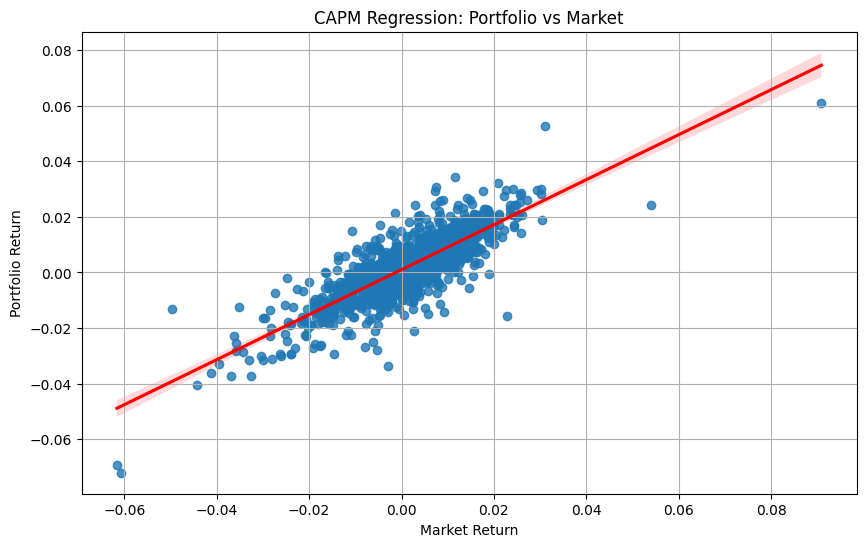

In [ ]:
#Visualize the regression:

plt.figure(figsize=(10, 6))
sns.regplot(x=data_port_market["market"], y=data_port_market["portfolio"], line_kws={"color": "red"})
plt.xlabel("Market Return")
plt.ylabel("Portfolio Return")
plt.title("CAPM Regression: Portfolio vs Market")
plt.grid(True)
plt.show()

In [ ]:
#Data collection and function to calculate the hedge ratio:

def hedge_ratio(Portfolio_value, beta, Fut_price, Fut_multiplier):
  return beta * Portfolio_value / (Fut_price * Fut_multiplier)

ticker_Fut = ["ES=F"] + log_returns.columns.tolist()
raw_port_Fut = get_data(ticker_Fut, period)
cleaned_port_data = NaN_cleaner(raw_port_Fut)
Fut_data = cleaned_port_data["ES=F"]
port_data = cleaned_port_data.drop(columns=["ES=F"]) @ optimal_weights
Fut_return = log_returns_calc(Fut_data)
port_return = log_returns_calc(port_data)
data_port_Fut = pd.concat([Fut_data, port_data], axis=1)
data_port_Fut.columns = ["Fut", "portfolio"]

[*********************100%***********************]  19 of 19 completed


In [ ]:
#Calculate the hedge ratio:

portfolio_value = 10000000 #Notional value

beta, Fut_price, Fut_multiplier = beta, Fut_data.iloc[-1], 50
hedge_contracts = hedge_ratio(portfolio_value, beta, Fut_price, Fut_multiplier)
hedge_contracts = int(np.round(hedge_contracts))

print("")
print(f"Short {hedge_contracts} S&P 500 futures contracts to hedge the portfolio.")


Short 29 S&P 500 futures contracts to hedge the portfolio.


## 4. Monte Carlo VaR Simulation (via GBM)
We simulate the future value of the hedged portfolio using a Geometric Brownian Motion (GBM) model for log-returns. This allows us to estimate the Value-at-Risk (VaR) at a 99% confidence level under realistic continuous compounding assumptions.

In [114]:
#Parameters:

n_days = 1 #number of days to simulate
c = 95 #confidence level %

mu_p, sigma_p = port_return.mean() * n_trading, port_return.std() * np.sqrt(n_trading) #Mean and variance of the portfolio returns
mu_f, sigma_f = Fut_return.mean() * n_trading, Fut_return.std() * np.sqrt(n_trading)  #Mean and variance of the future returns
rho = data_port_Fut.corr().iloc[1,0]  #correlation of the future and the portfolio

In [115]:
#Simulation:

n_sim = 10000 #number of simulations

S0_p = port_data.iloc[-1] #portfolio initial price
S0_f = Fut_data.iloc[-1] #future initial price

T = n_days/n_trading
dt = T

z_1 = np.random.normal(0, 1, n_sim)
z_2 = np.random.normal(0, 1, n_sim)
w_f = z_1
w_p = rho * w_f + np.sqrt(1-rho**2) * z_2

#simulation of the returns:
r_p = (mu_p - sigma_p**2/2) * dt + sigma_p * np.sqrt(dt) * w_p
r_f = (mu_f - sigma_f**2/2) * dt + sigma_f * np.sqrt(dt) * w_f

#simulation of the prices:
S_p = S0_p * np.exp(r_p)
S_f = S0_f * np.exp(r_f)

In [116]:
#VaR calculation, hedged vs unhedged:

return_unhedged = (S_p - S0_p) / S0_p
delta_f = ((S_f - S0_f)) * hedge_contracts * Fut_multiplier

VaR_unhedged = -np.percentile(return_unhedged * portfolio_value, 100 - c)
VaR_hedged = -np.percentile(return_unhedged * portfolio_value - delta_f, 100-c)

print(f"GBM {n_days}-day {c}% VaR Unhedged: ${VaR_unhedged:,.0f}")
print(f"GBM {n_days}-day {c}% VaR Hedged:   ${VaR_hedged:,.0f}")


GBM 1-day 95% VaR Unhedged: $167,071
GBM 1-day 95% VaR Hedged:   $76,569


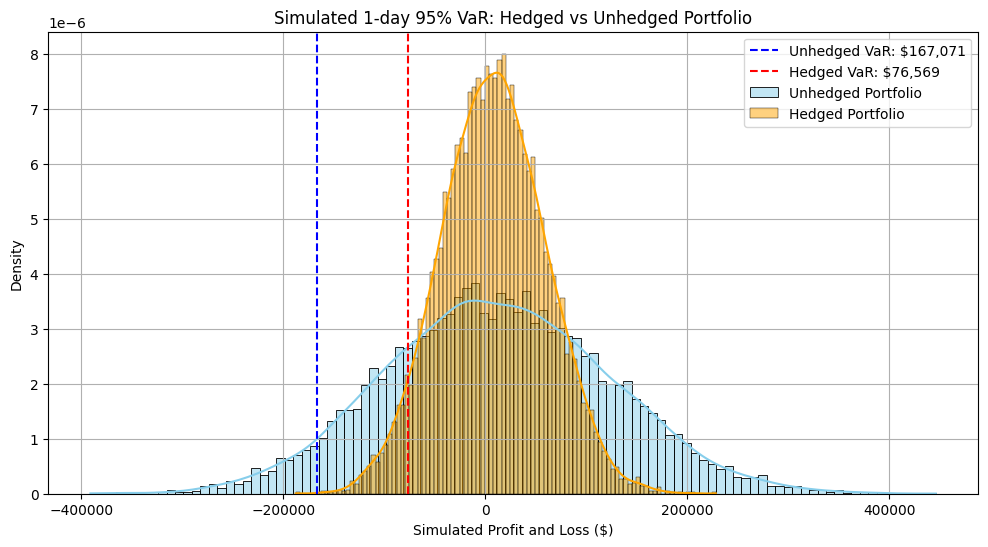

In [117]:
# Plotting the distributions of hedged vs unhedged simulated portfolio P&L
plt.figure(figsize=(12, 6))

# Unhedged P&L distribution
sns.histplot(return_unhedged * portfolio_value, bins=100, kde=True, color='skyblue', label="Unhedged Portfolio", stat='density')

# Hedged P&L distribution
sns.histplot((return_unhedged * portfolio_value - delta_f), bins=100, kde=True, color='orange', label="Hedged Portfolio", stat='density')

# Plot the VaR lines
plt.axvline(-VaR_unhedged, color='blue', linestyle='--', label=f'Unhedged VaR: ${VaR_unhedged:,.0f}')
plt.axvline(-VaR_hedged, color='red', linestyle='--', label=f'Hedged VaR: ${VaR_hedged:,.0f}')

# Labels and title
plt.title(f"Simulated {n_days}-day {c}% VaR: Hedged vs Unhedged Portfolio")
plt.xlabel("Simulated Profit and Loss ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


##Colnclusion

Conclusion
This project demonstrates a robust end-to-end Value-at-Risk (VaR) framework for a multi-asset portfolio, including optimal allocation, risk factor modeling via CAPM, and hedge implementation using futures. By simulating market dynamics through Geometric Brownian Motion, we quantify and compare the tail risks of hedged and unhedged positions. The results clearly show that systematic risk can be significantly reduced through targeted hedging—highlighting the practical value of quantitative modeling for risk management.